<a href="https://colab.research.google.com/github/wherzberg/CNN-Introduction/blob/main/Smiley_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smiley Image U-Net
 - Created by Billy Herzberg
 - william.herzberg@marquette.edu

This notebook will generate simulated images that have an input and a truth. If the input has a smiley face, the output will have a ring in the same location. The input has noise while the output does not.

# Import Libraries and Define Functions

In [1]:
import tensorflow as tf
print("Using Tensorflow version",tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib        as mpl                 # There are a few other things needed from matplotlib

# Also set some things for plotting
plt.style.use('seaborn-whitegrid')
plt.rcParams["axes.grid"] = False

Using Tensorflow version 2.6.0


In [2]:
def genData(N,n,m,p,A,B):
    # This function will generate a data set of blurry smiley face images
    # Inputs:
    # -> N = Number of samples
    # -> n = height of the images
    # -> m = width of the images
    # -> p = probability of a smiley face
    # -> A = magnitude of the smiley feature
    # -> B = standard deviation of the blurry noise
    # Outputs:
    # -> data = dictionary with X and Y
    #       X = a [N,n,m,1] array of input image samples
    #       Y = a [N,n,m,1] array of truth image samples

    # Start by building the blurry backgrounds for X and a vector of 0's for Y
    X = np.random.normal(loc=0,scale=B,size=[N,n,m,1])
    Y = np.ones(shape=[N,n,m,1])*0.9

    # Then loop through each sample and maybe put a smiley
    for k in range(N):

        r = np.random.uniform()
        if r < p: # We need to add a smiley
            
            # Find the top left corner of the smiley
            row = np.random.randint(low=1,high=(n-3))
            col = np.random.randint(low=1,high=(m-3))

            # Then increase the values at the eyes and mouth
            X[k,row  ,col  ,0] += A
            X[k,row  ,col+2,0] += A
            X[k,row+2,col  ,0] += A
            X[k,row+2,col+1,0] += A
            X[k,row+2,col+2,0] += A

            # Also if a smiley was placed, put a ring in the output
            val = 0.5
            Y[k,row  ,col  ,0] = val
            Y[k,row  ,col+1,0] = val
            Y[k,row  ,col+2,0] = val
            Y[k,row+1,col  ,0] = val
            Y[k,row+1,col+2,0] = val
            Y[k,row+2,col  ,0] = val
            Y[k,row+2,col+1,0] = val
            Y[k,row+2,col+2,0] = val

    # Now prepare the output as a dictionary and return
    data = {
        'X': X,
        'Y': Y
    }
    return data

print("genData is defined")

genData is defined


In [3]:
def displaySample(X,Ypred,Y,k,A,B):
    # This function will display one sample of input and output data
    # Inputs:
    # ->     X = a [N,n,m,1] array of input image samples
    # -> Ypred = a [N,n,m,1] array of output image samples
    # ->     Y = a [N,n,m,1] array of truth image samples
    # ->     k = the sample number to display


    # Pick out the sample
    x =     X[k,:,:,0].squeeze()
    p = Ypred[k,:,:,0].squeeze()
    y =     Y[k,:,:,0].squeeze()
    
    # Set up the figure and axes
    fig, axs = plt.subplots(1,3,figsize=(15,5))

    # Set the norm and colormap
    norm0 = mpl.colors.Normalize(vmin=-3*B, vmax=3*B+A)
    norm1 = mpl.colors.Normalize(vmin=0, vmax=1)
    cmap='cool'

    # Display the images
    axs[0].imshow(x, norm=norm0, cmap=cmap)
    axs[0].set_title('Input')
    axs[0].axis('off')
    fig.colorbar(plt.cm.ScalarMappable(norm=norm0, cmap=cmap), ax=axs[0], orientation='horizontal', shrink=0.75)
    axs[1].imshow(p, norm=norm1, cmap=cmap)
    axs[1].set_title('Output')
    axs[1].axis('off')
    fig.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=axs[1], orientation='horizontal', shrink=0.75)
    axs[2].imshow(y, norm=norm1, cmap=cmap)
    axs[2].set_title('Truth')
    axs[2].axis('off')
    fig.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=axs[2], orientation='horizontal', shrink=0.75)
    
print("displaySample is defined")

displaySample is defined


In [93]:
def displayIntermediateOutput(model,layer,X,Y,k,A,B):
    # This function will display output from a layer in the model for sample k 
    # from set X.
    # Inputs:
    # -> model = the model to take intermediate output from
    # -> layer = the layer number to take output from
    # ->     X = data size [N,n,m,1] array of input image samples
    # ->     Y = data size [N,n,m,1] array of truth image samples
    # ->     k = index of the data sample to be plotted

    # Pick out the sample, keeping dimensions for input
    x = X[k,:,:,:].reshape(1,X.shape[1],X.shape[2],1)
    y = Y[k,:,:,0].squeeze()

    # snip the model so the output is at the desired layer
    model_snip = tf.keras.Model( inputs=model.input, outputs=model.layers[layer].output )

    # Send the sample through both models
    #ypred1 = model.predict(x).squeeze()  # This works but gives a warning so below is used instead. I don't get it
    #ypred2 = model_snip.predict(x).squeeze()  # This works but gives a warning so below is used instead. I don't get it
    ypred1 = np.array(model.predict_step(x)).squeeze()
    ypred2 = np.array(model_snip.predict_step(x)).squeeze()
    
    # Reshape the intermediate output (align channels horizontally)
    ypred2 = ypred2.reshape((ypred2.shape[0],ypred2.shape[1],-1))
    for i in range(ypred2.shape[2]):
        if i == 0:
            ypred2_ = ypred2[:,:,i].squeeze()
        else:
            ypred2_ = np.hstack(( ypred2_, np.ones((ypred2.shape[0],1)), ypred2[:,:,i].squeeze() ))
    ypred2 = ypred2_ #ypred2.reshape((ypred2.shape[0],-1))

    # Set up the figure and axes
    fig, axs = plt.subplots(1,3,figsize=(25,5))

    # Set the norm and colormap
    norm0 = mpl.colors.Normalize(vmin=-3*B, vmax=3*B+A)
    norm1 = mpl.colors.Normalize(vmin=0, vmax=1)
    cmap='cool'

    # Display the images
    axs[0].imshow(x.squeeze(), norm=norm0, cmap=cmap)
    axs[0].set_title('Input')
    axs[0].axis('off')
    fig.colorbar(plt.cm.ScalarMappable(norm=norm0, cmap=cmap), ax=axs[0], orientation='horizontal', shrink=0.75)
    axs[1].imshow(ypred2, norm=norm1, cmap=cmap)
    axs[1].set_title('Intermediate Output')
    axs[1].axis('off')
    fig.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=axs[1], orientation='horizontal', shrink=0.75)
    axs[2].imshow(y, norm=norm1, cmap=cmap)
    axs[2].set_title('Truth')
    axs[2].axis('off')
    fig.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=axs[2], orientation='horizontal', shrink=0.75)

print("displayIntermediateOutput is defined")

displayIntermediateOutput is defined


In [94]:
def displayFilterChannel(model,layer,index1,index2):
    # Display a filter from a convolutional layer
    # Inputs:
    # -> model  = the model to take intermediate output from
    # -> layer  = the layer number to take output from
    # -> index1 = the filter channel (what channel of the input)
    # -> index2 = the filter index (which filter to look at)

    # Get the weights from the layer
    W = model.layers[layer].get_weights()[0]

    # Get the specific filter channel
    w = W[:,:,index1,index2].squeeze()

    # Make a title
    t = "Kernel Values"

    # Display the image
    plt.imshow(w)
    plt.title(t)
    plt.axis('off')
    plt.colorbar()
    plt.show()

print("displayFilterChannel is defined")

displayFilterChannel is defined


# Simulate a Data Set

In [97]:
N = 500    # Number of samples
n = 12     # Height
m = 12     # Width
p = 0.5    # Probability of a smiley
A = 3      # Amplitude of smiley
B = 1      # Standard deviation of normal noise
data = genData(N,n,m,p,A,B)
X = data['X']    # Input images
Y = data['Y']    # Truth images

# Display shapes and a sample
print("The shape of X:", data['X'].shape)
print("The shape of Y:", data['Y'].shape)

The shape of X: (500, 12, 12, 1)
The shape of Y: (500, 12, 12, 1)


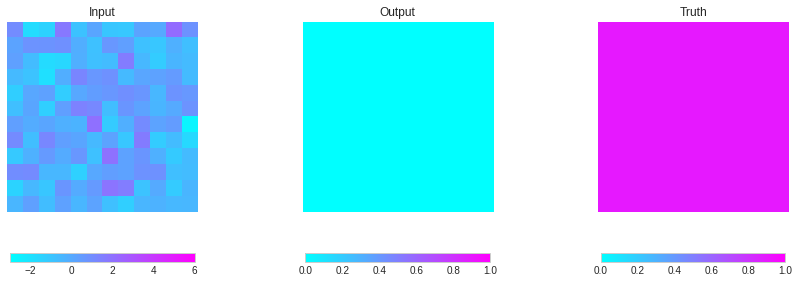

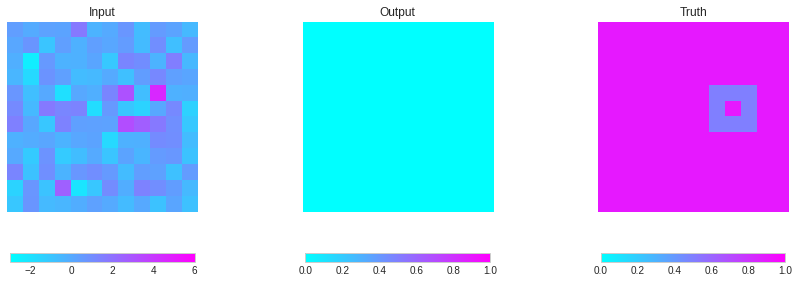

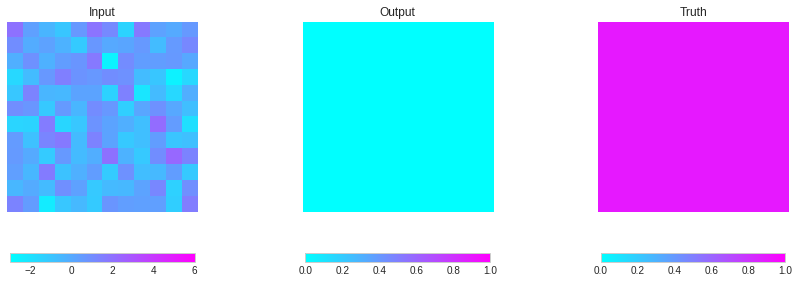

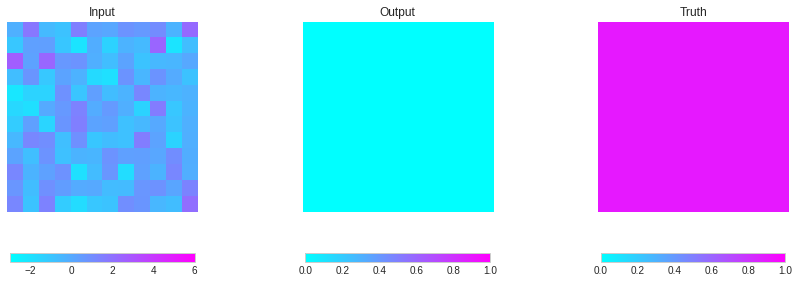

In [98]:
for k in [0,1,2,3]:
    displaySample(X,np.zeros(shape=X.shape),Y,k,A,B)

In [99]:
# Split into training and testing
train_size = 400
Xtrain = X[           :train_size, :, :, : ]
Xtest  = X[ train_size:          , :, :, : ]
Ytrain = Y[           :train_size, :, :, : ]
Ytest  = Y[ train_size:          , :, :, : ]

# Display shapes
print("The shape of Xtrain:", Xtrain.shape)
print("The shape of Xtest: ",  Xtest.shape)
print("The shape of Ytrain:", Ytrain.shape)
print("The shape of Ytest: ",  Ytest.shape)

The shape of Xtrain: (400, 12, 12, 1)
The shape of Xtest:  (100, 12, 12, 1)
The shape of Ytrain: (400, 12, 12, 1)
The shape of Ytest:  (100, 12, 12, 1)


# Build a CNN Model

In [109]:
# Build a UNet
X0 = tf.keras.Input( shape=( n,m,1 ) )

# Convolution
C1 = tf.keras.layers.Conv2D(
    filters     = 5,
    kernel_size = (3,3),
    strides     = (1,1),
    padding     = 'same',
    activation  = 'relu'
)(X0)

# Pool
P1 = tf.keras.layers.MaxPool2D(
    pool_size    = (2,2)
)(C1)

# Convolution
C2 = tf.keras.layers.Conv2D(
    filters     = 10,
    kernel_size = (3,3),
    strides     = (1,1),
    padding     = 'same',
    activation  = 'relu'
)(P1)

# Upsample
U1 = tf.keras.layers.Conv2DTranspose(
    filters     = 5, 
    kernel_size = (3,3), 
    strides     = (2,2), 
    padding='same'
)(C2)

# Add
A1 = tf.keras.layers.Concatenate()([U1, C1])

# Convolution
C3 = tf.keras.layers.Conv2D(
    filters     = 1,
    kernel_size = (3,3),
    strides     = (1,1),
    padding     = 'same',
    activation  = 'relu'
)(A1)

model = tf.keras.Model(inputs=X0, outputs=C3)
model.summary()

Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 12, 12, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 12, 12, 5)    50          input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 6, 6, 5)      0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 6, 6, 10)     460         max_pooling2d_7[0][0]            
___________________________________________________________________________________________

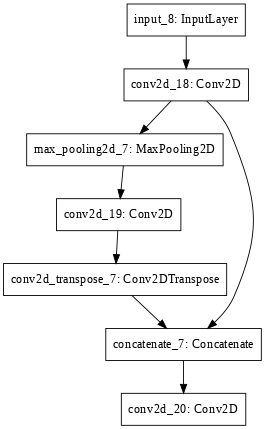

In [110]:
tf.keras.utils.plot_model( model, dpi=64 )

In [111]:
# Compile
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss      = 'mse'
)
print("Model Compiled")

Model Compiled


Untrained Predictions


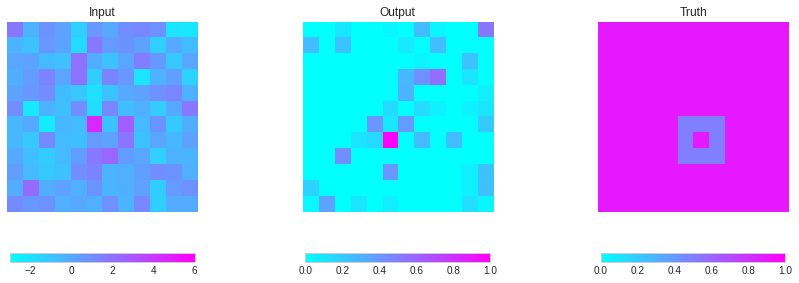

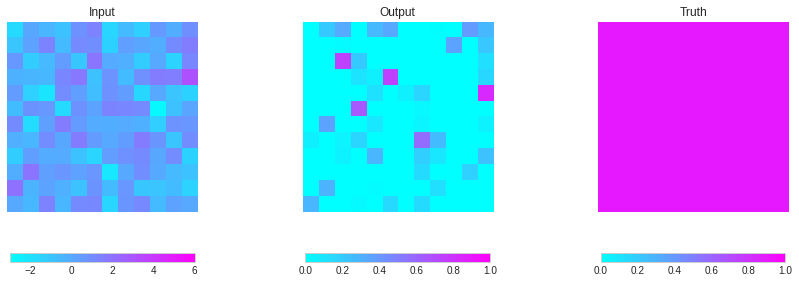

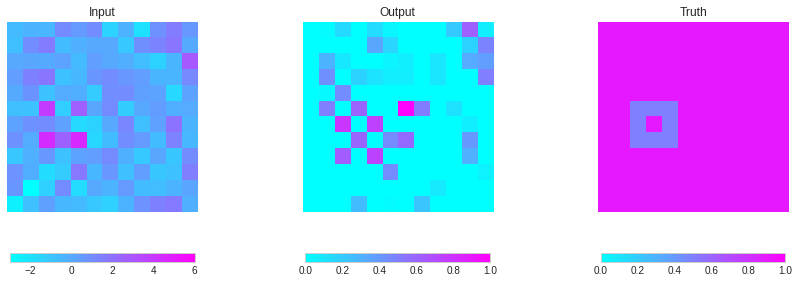

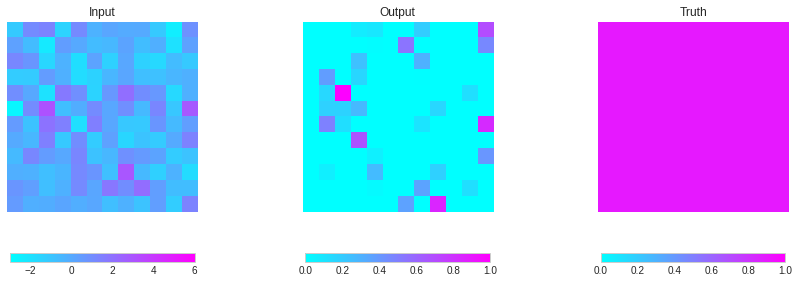

In [112]:
# Predict
YtestPred = np.array(model.predict_step(Xtest))
print("Untrained Predictions")
for k in [0,1,2,3]:
    displaySample(Xtest,YtestPred,Ytest,k,A,B)

# Train the Model

In [113]:
hist = model.fit(
    x = Xtrain,
    y = Ytrain,
    validation_data = (Xtest, Ytest),
    batch_size = 5,
    epochs = 100
)

Epoch 1/100
80/80 [==============================] - 1s 5ms/step - loss: 0.0623 - val_loss: 0.0047
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 4/100
80/80 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
80/80 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/100
80/80 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 11/

# Evaluate the Model

Trained Predictions


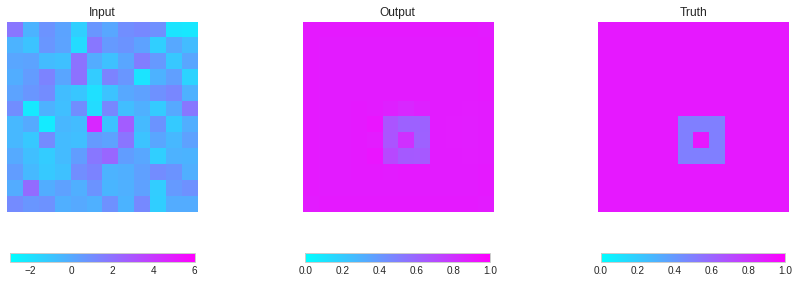

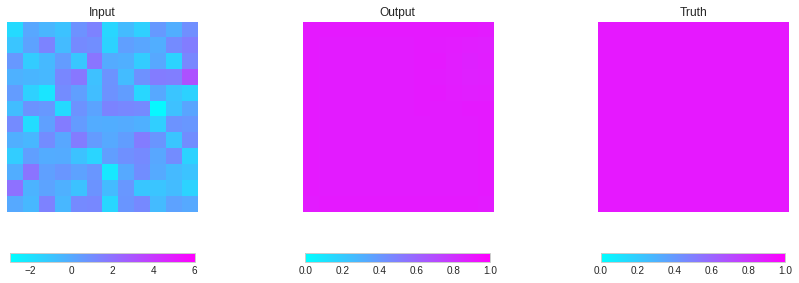

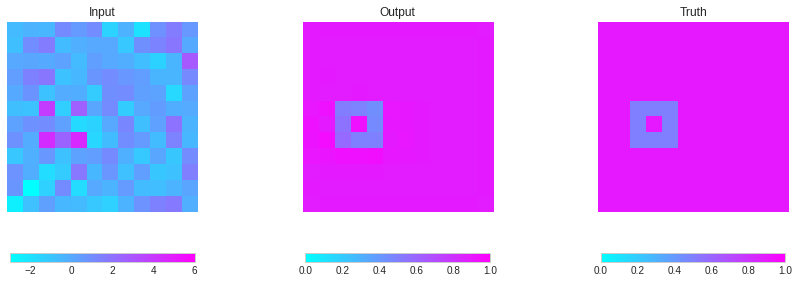

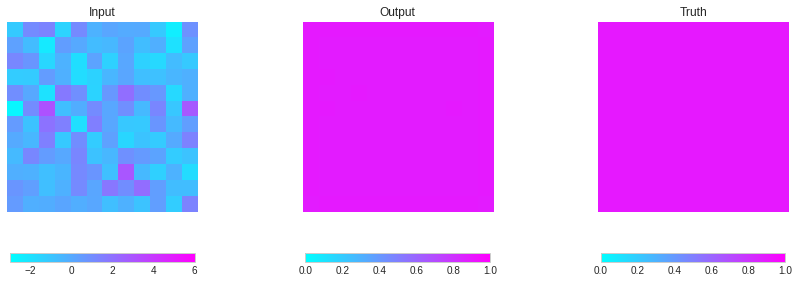

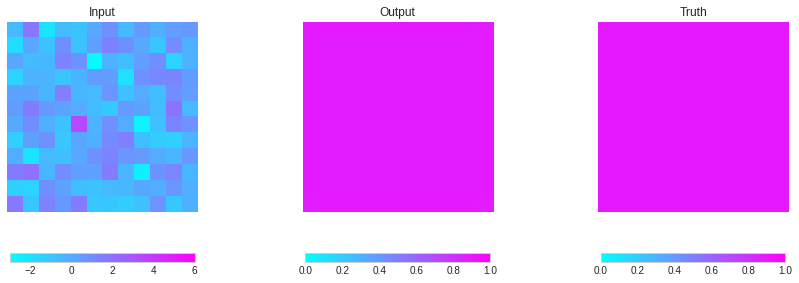

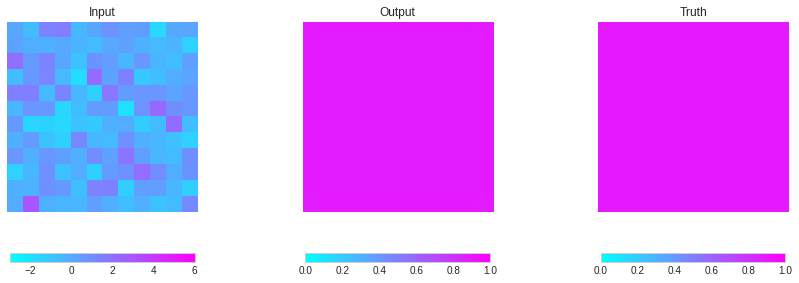

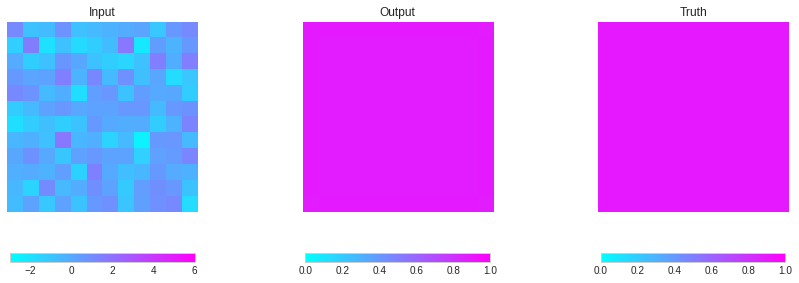

In [114]:
# Predict
YtestPred = np.array(model.predict_step(Xtest))
print("Trained Predictions")
for k in [0,1,2,3,4,5,6]:
    displaySample(Xtest,YtestPred,Ytest,k,A,B)

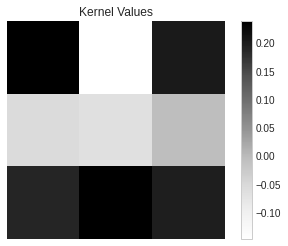

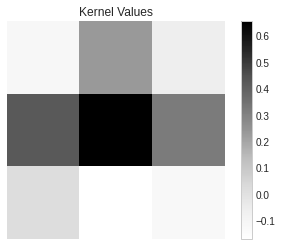

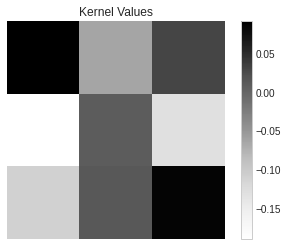

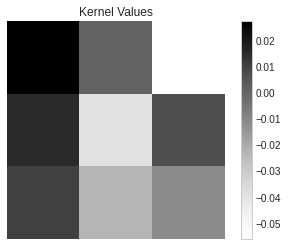

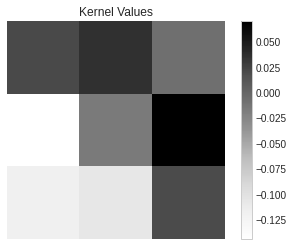

In [115]:
# Display an image of the kernels
l = 1  # layer index
ind1 = 0  # channel index
ind2 = 0  # filter number
for l in [1,3,4]:
    displayFilterChannel(model,l,ind1,ind2)
displayFilterChannel(model,6,ind1,ind2)
displayFilterChannel(model,6,ind1+1,ind2)

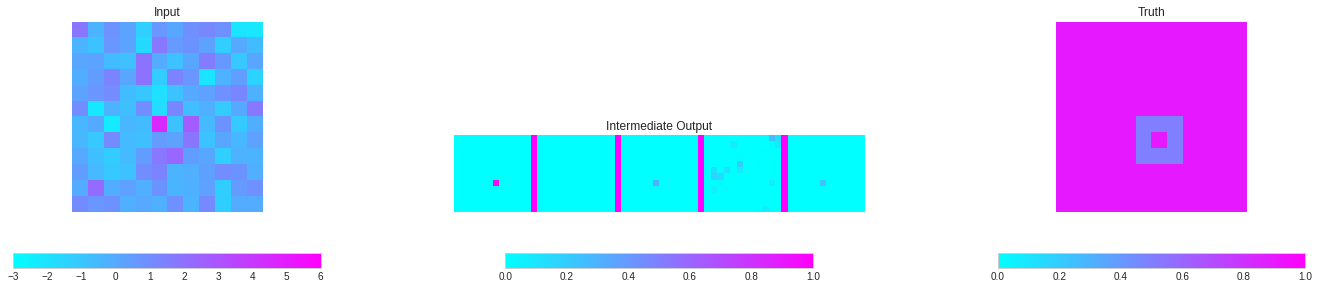

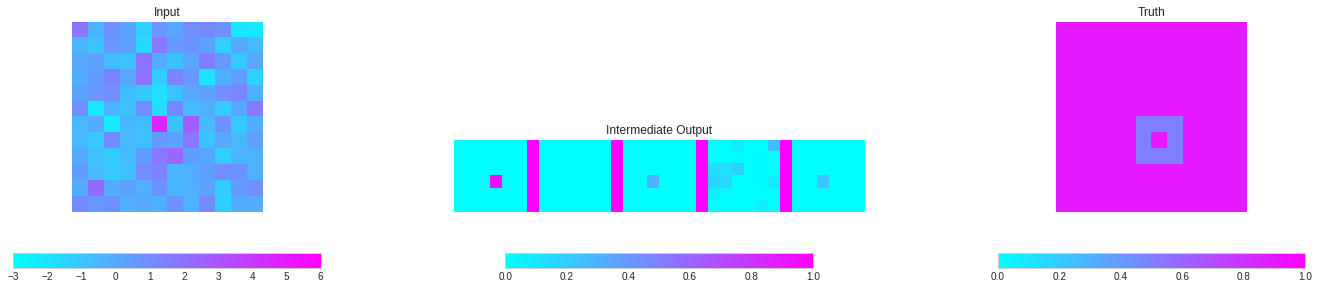

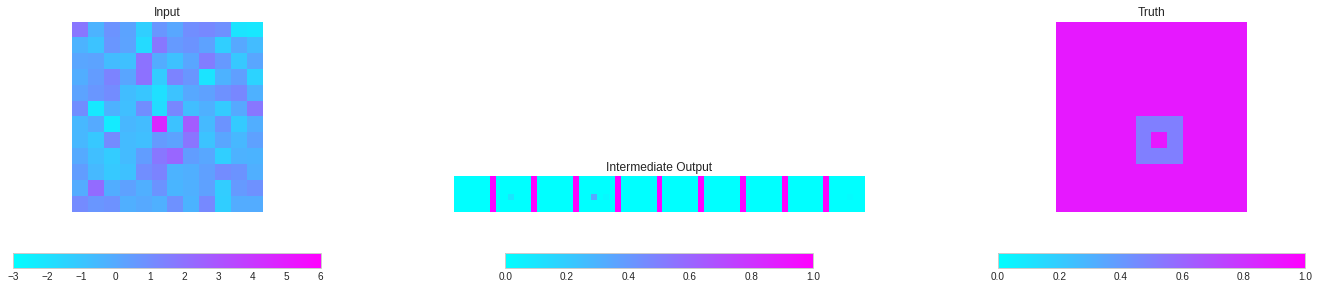

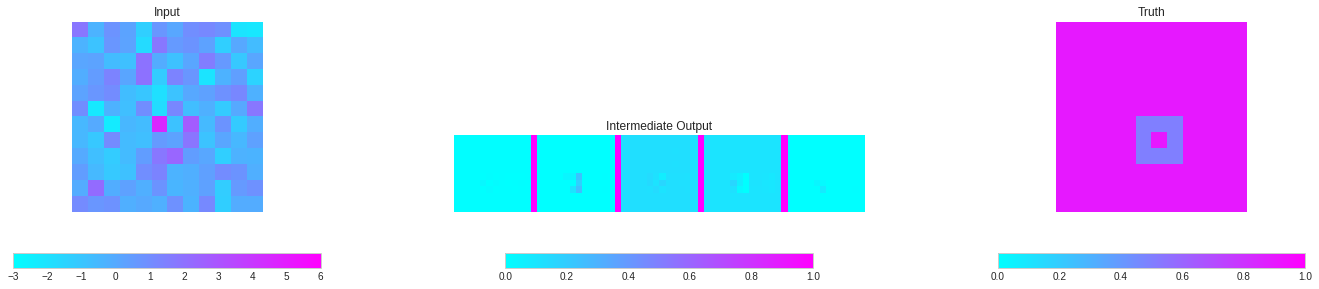

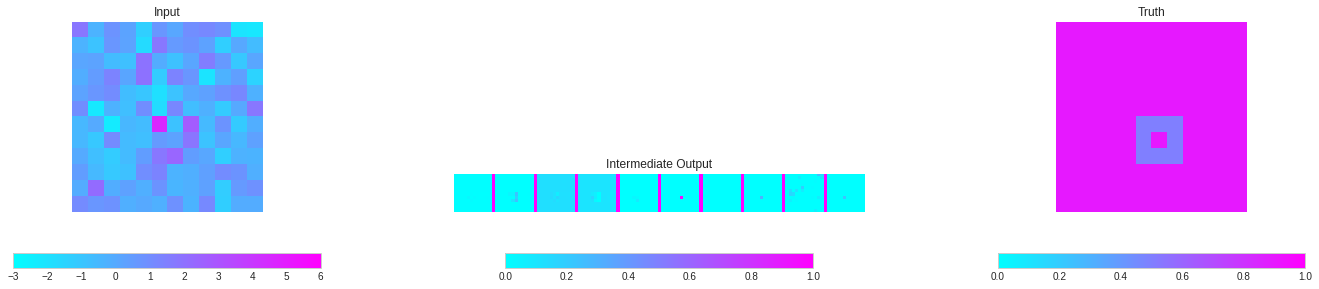

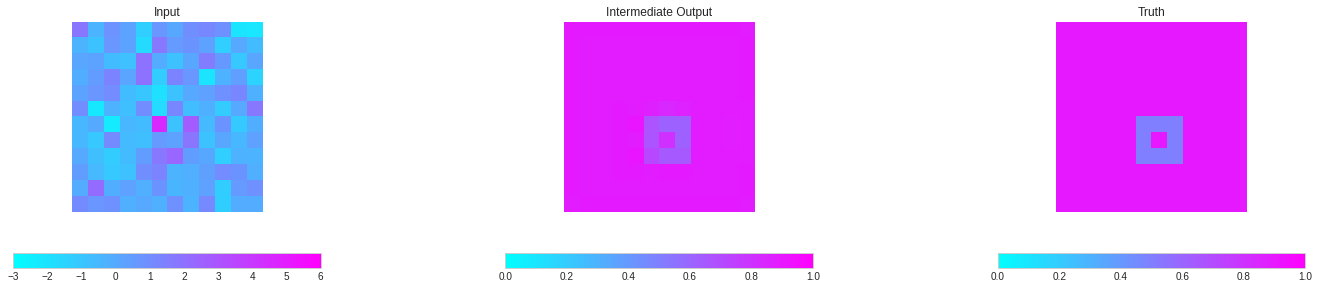

In [116]:
k = 0 # Pick a sample
for l in [1,2,3,4,5,6]:
    displayIntermediateOutput(model,l,Xtest,Ytest,k,A,B)

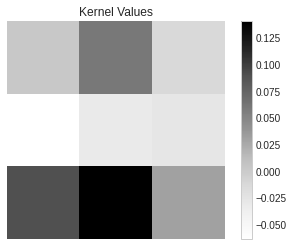

In [123]:
l = 1  # layer index
ind1 = 0  # channel index
ind2 = 4  # filter number
displayFilterChannel(model,l,ind1,ind2)

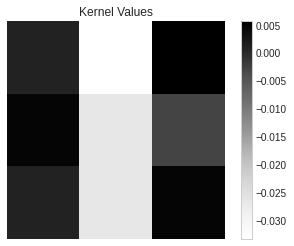

In [134]:
l = 6  # layer index
ind1 = 9  # channel index
ind2 = 0  # filter number
displayFilterChannel(model,l,ind1,ind2)